# SIR model - Joint Approach

Solving the SIR model with constant transmission rate $\beta$ and recovery rate $\delta$.

$$
\begin{cases}
\frac{dS}{dt} &= -\frac{\beta}{N} I S, \\
\frac{dI}{dt} &= \frac{\beta}{N} I S - \delta I, \\
\frac{dR}{dt} &= \delta I,
\end{cases}
$$

where $t \in [0, 90]$ and with the initial conditions $S(0) = N - 1$, $I(0) = 1$, and $R(0) = 0$.

## Environment Setup

Importing libraries with first loading .env file, which specifies which backend DeepXDE should use

In [1]:
from dotenv import load_dotenv

load_dotenv()

import torch
import deepxde as dde
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
from scipy.integrate import odeint

if torch.backends.mps.is_available():
  torch.set_default_device("mps")

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Apply some configurations to the plots.

In [2]:
plt.rc('text', usetex=False)
plt.rc('font', family='serif')

sns.set_theme(style="darkgrid")

Set random seed for reproducibility

In [3]:
seed = 1303

np.random.seed(seed)
torch.manual_seed(seed)
dde.config.set_random_seed(seed)

Define the output directories for saving the plots and data.

In [4]:
data_dir = "data"
assets_dir = "assets"

## Synthetic data generation

Building a SIR model to generate a discrete synthetic dataset in a closed time interval.

This dataset will be used as a starting point for creating both the true solution used during the l2 regularization term and observed data used during the training of the network.

### System configuration

The following parameters are used (using Italy as reference):

In [5]:
N = 56e6  # total population
delta = 1 / 5  # recovery rate (1 / mean infectious period)
r0 = 3.0  # basic reproduction number
real_beta = delta * r0  # transmission rate

The following time interval is used:

In [6]:
T0, TF = 0, 90  # (days)

### System definition

Define the SIR model and the initial conditions.

In [7]:
def SIR(x, t, delta, beta, N):
  S, I, R = x
  _lambda = beta * I / N
  dSdt = -_lambda * S
  dIdt = _lambda * S - delta * I
  dRdt = delta * I
  return [dSdt, dIdt, dRdt]


S0 = N - 1
I0 = 1
R0 = 0

Define a function to generate a discrete solution for the SIR model based on a time interval.

In [8]:
def solve_sir(t):
  x = odeint(SIR, [S0, I0, R0], t, args=(delta, real_beta, N))
  S = x[:, 0]
  I = x[:, 1]
  R = x[:, 2]
  return S, I, R

### Data generation

Generate a synthetic dataset and a synthetic observation of $I(t)$ by adding some noise to the true solution.

In [9]:
t_data = np.linspace(T0, TF, TF - T0 + 1)
S_data, I_data, R_data = solve_sir(t_data)

I_obs = np.random.poisson(I_data)

Plot the synthetic dataset and the observed $I(t)$.

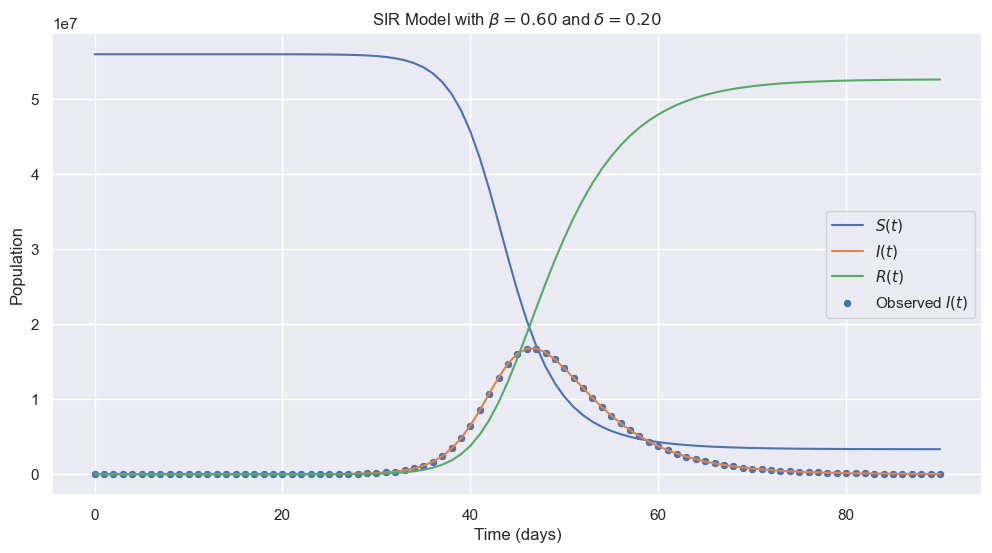

In [10]:
plt.subplots(figsize=(12, 6))

sns.lineplot(x=t_data, y=S_data, label=r"$S(t)$")
sns.lineplot(x=t_data, y=I_data, label=r"$I(t)$")
sns.lineplot(x=t_data, y=R_data, label=r"$R(t)$")
sns.scatterplot(x=t_data, y=I_obs, label=r"Observed $I(t)$")

plt.title(
  f"SIR Model with $\\beta = {real_beta:.2f}$ and $\\delta = {delta:.2f}$"
)
plt.xlabel(r"Time (days)")
plt.ylabel(r"Population")

plt.savefig(f"{assets_dir}/synthetic_data.png")

## Data Scaling

Scale both dataset and observation by a constant $C$ and into a time interval $[0, 1]$.

This is necessary to avoid numerical instability during the training of the network.

Define the scaling and unscaling functions.

In [11]:
C = 1e5


def scale_time(t):
  return t / TF


def unscale_time(t):
  return t * TF


def scale_population(x):
  return x / C


def unscale_population(x):
  return x * C

From now on, we will only use the scaled data.

In [12]:
t_data = scale_time(t_data.reshape(-1, 1))

I_obs = scale_population(I_obs.reshape(-1, 1))

## Modelling a Joint Approach

Define a PINN that tries to solve the SIR model by reducing at the same time the error generated by the observed data, the error generated by the ODE system, and the error generated by initial conditions mismatch.

### Model configuration

The following hyperparameters are used for the model:

In [13]:
layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"

first_optimizer = "adam"
second_optimizer = "L-BFGS"
lr = 0.001
loss_function = "MSE"

batch_size = 1000
iterations = 20000

### Model definition

Define the time domain geometry, scaled to the range [0, 1].

In [14]:
geom = dde.geometry.TimeDomain(scale_time(T0), scale_time(TF))

Define the beta parameter as a trainable variable with initial guess.

In [15]:
beta = dde.Variable(0.5)

Define the ODE system, adjusted to use the scaled data.

In [16]:
C1 = (TF - T0) * C / N
C2 = (TF - T0) * delta


def ode_system(t, y):
  S = y[:, 0:1]
  I = y[:, 1:2]
  _ = y[:, 2:3]
  dS_t = dde.grad.jacobian(y, t, i=0)
  dI_t = dde.grad.jacobian(y, t, i=1)
  dR_t = dde.grad.jacobian(y, t, i=2)

  res_s = dS_t - (- C1 * beta * I * S)
  res_i = dI_t - (C1 * beta * I * S - C2 * I)
  res_r = dR_t - (C2 * I)
  return torch.cat([res_s, res_i, res_r], dim=1)

Define the initial condition. The function will simply return the scaled initial condition for each component. The `boundary` function will be used to apply the ICs only in the correct boundary, which is the initial time. We could've compare the x value to T0, but we can simply use the `on_initial` parameter.

In [17]:
def boundary(_, on_initial):
  return on_initial


ic_S = dde.icbc.IC(geom, lambda t: scale_population(S0), boundary, component=0)
ic_I = dde.icbc.IC(geom, lambda t: scale_population(I0), boundary, component=1)
ic_R = dde.icbc.IC(geom, lambda t: scale_population(R0), boundary, component=2)

Define the boundary condition using the observed $I(t)$ data. This Dirichlet boundary condition, applied to the second component of the solution, will be used to ensure that the Infected population follows the observed data by minimizing the error between the predictions and the observations.

In [18]:
observe_I = dde.icbc.PointSetBC(t_data, I_obs, component=1)

Construct the mathematical problem with the ICs and BCs.

It will use the time domain geometry as domain, the ODE system to compute the loss from the equations and the ICs and BCs to compute the loss from the data, observations and initial conditions.

We use the t_data series as points to train the model and 2 points on the boundary (the start and the end of the time domain).

In [19]:
data = dde.data.PDE(
  geom,
  ode_system,
  [ic_S, ic_I, ic_R, observe_I],
  num_boundary=2,
  anchors=t_data,
  # num_test=20,
)

Define the network as 3 FNNs training in parallel, one for each component of the solution.

In [20]:
class ThreeNets(torch.nn.Module):
  def __init__(self, layer_size, activation, initializer):
    super().__init__()
    self.net_S = dde.nn.pytorch.FNN(layer_size, activation, initializer)
    self.net_I = dde.nn.pytorch.FNN(layer_size, activation, initializer)
    self.net_R = dde.nn.pytorch.FNN(layer_size, activation, initializer)

    self.regularizer = None

  def forward(self, x):
    S_next = self.net_S(x)
    I_next = self.net_I(x)
    R_next = self.net_R(x)
    return torch.cat([S_next, I_next, R_next], dim=1)


net = ThreeNets(layer_size, activation, initializer)

Finally, define the model as the Neural Network and the problem it tries to solve.

In [21]:
model = dde.Model(data, net)

### Model training

A two-stage training is used to train the model. First, we train using the `adam` optimizer and the loss function. Then, we switch to the `L-BFGS` optimizer to faster converge.

Compile and train the model using `adam`.
At this state, we include the beta parameter as an external trainable variable.

In [22]:
variable = dde.callbacks.VariableValue(
  beta,
  period=1000,
  filename=f"{data_dir}/beta_var.dat",
)

model.compile(
  optimizer=first_optimizer,
  lr=lr,
  loss=loss_function,
  # loss_weights=[1] * 4, TODO understand loss_weights
  external_trainable_variables=[beta],
)

loss_history, train_state = model.train(
  batch_size=batch_size,
  iterations=iterations,
  callbacks=[variable],
)

Compiling model...
'compile' took 2.381226 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [7.84e+00, 3.14e+05, 1.00e-10, 0.00e+00, 3.19e+03]    [7.84e+00, 3.14e+05, 1.00e-10, 0.00e+00, 3.19e+03]    []  
1000      [9.25e+01, 2.47e+05, 9.24e-04, 7.34e-02, 2.79e+03]    [9.25e+01, 2.47e+05, 9.24e-04, 7.34e-02, 2.79e+03]    []  
2000      [1.66e+01, 2.01e+05, 2.78e-06, 9.23e-02, 2.00e+03]    [1.66e+01, 2.01e+05, 2.78e-06, 9.23e-02, 2.00e+03]    []  
3000      [8.28e+01, 1.61e+05, 1.85e-03, 1.61e-01, 1.52e+03]    [8.28e+01, 1.61e+05, 1.85e-03, 1.61e-01, 1.52e+03]    []  
4000      [3.88e+01, 1.27e+05, 2.62e-03, 3.02e-01, 1.16e+03]    [3.88e+01, 1.27e+05, 2.62e-03, 3.02e-01, 1.16e+03]    []  
5000      [2.10e+02, 9.70e+04, 1.36e-03, 4.77e-01, 8.55e+02]    [2.10e+02, 9.70e+04, 1.36e-03, 4.77e-01, 8.55e+02]    []  
6000      [4.49e+01, 7.16e+04, 5.44e-04, 8.02e-01, 6.14e+02]    [4.

Fine-tune the model using `L-BFGS` optimizer.

In [23]:
model.compile(
  optimizer=second_optimizer,
  loss=loss_function
)

_, _ = model.train(
  callbacks=[variable],
  batch_size=batch_size
)

Compiling model...
'compile' took 0.001437 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
20000     [3.61e+00, 7.54e-03, 2.52e-04, 3.91e-03, 1.80e+01]    [3.61e+00, 7.54e-03, 2.52e-04, 3.91e-03, 1.80e+01]    []  
21000     [6.97e-01, 1.04e-02, 4.95e-04, 4.60e-04, 2.52e+00]    [6.97e-01, 1.04e-02, 4.95e-04, 4.60e-04, 2.52e+00]    []  
21666     [2.66e-01, 1.68e-03, 1.06e-04, 1.63e-03, 1.71e+00]    [2.66e-01, 1.68e-03, 1.06e-04, 1.63e-03, 1.71e+00]    []  

Best model at step 21666:
  train loss: 1.98e+00
  test loss: 1.98e+00
  test metric: []

'train' took 113.367110 s



## Evaluation

Save the loss history and the model state into .dat files.

In [24]:
dde.saveplot(
  loss_history,
  train_state,
  issave=True,
  isplot=False,
  output_dir=data_dir
)

Saving loss history to data/loss.dat ...
Saving training data to data/train.dat ...
Saving test data to data/test.dat ...


### Plotting the results

Plot the loss history during training.

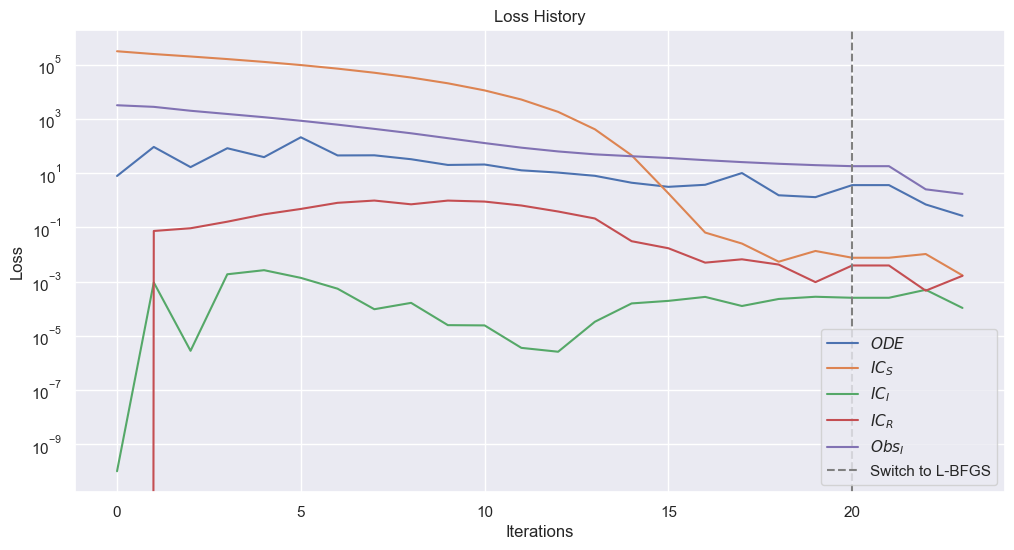

In [25]:
# TODO: check if the order is correct
columns = ["$ODE$", "$IC_S$", "$IC_I$", "$IC_R$", "$Obs_I$"]
losses = pd.DataFrame(loss_history.loss_train, columns=columns)

plt.subplots(figsize=(12, 6))

for column in columns:
  sns.lineplot(data=losses[column], label=column)

plt.axvline(
  iterations / batch_size,
  color="gray",
  linestyle="--",
  label="Switch to L-BFGS",
)
plt.yscale("log")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss History")
plt.legend()
plt.savefig(f"{assets_dir}/loss_history.png")
plt.show()

Plot the beta parameter during training.

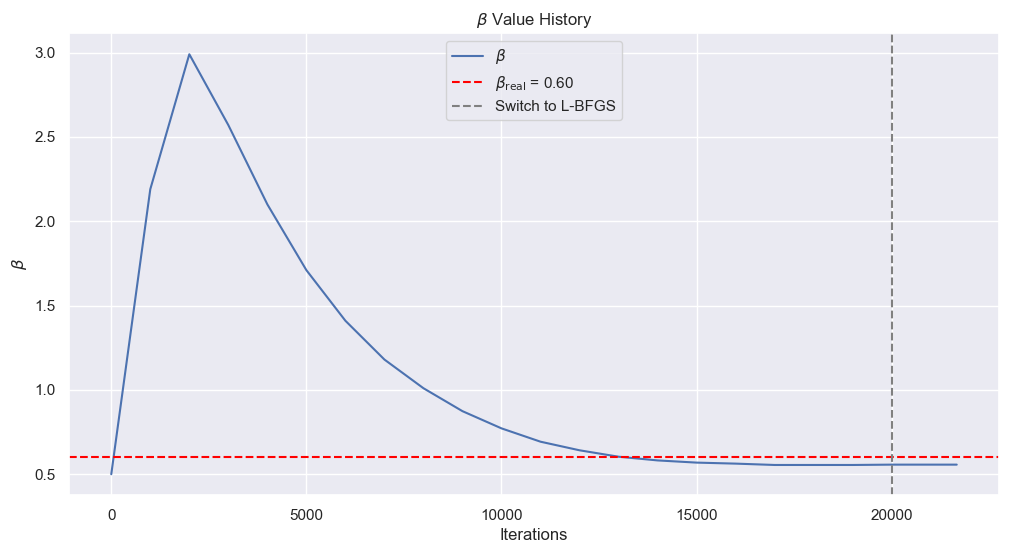

In [26]:
beta_x = []
beta_y = []

pattern = re.compile(r'(\d+)\s+\[([0-9.eE+-]+)\]')

with open(f"{data_dir}/beta_var.dat", "r") as f:
  for line in f:
    match = pattern.match(line)
    if match:
      iteration = int(match.group(1))
      beta = float(match.group(2))
      beta_x.append(iteration)
      beta_y.append(beta)

beta_values = pd.DataFrame(beta_y, index=beta_x, columns=["$\\beta$"])

plt.subplots(figsize=(12, 6))

sns.lineplot(data=beta_values)
plt.axhline(
  real_beta,
  color="red",
  linestyle="--",
  label=r"$\beta_{\mathrm{real}}$" + f" = {real_beta:.2f}",
)
plt.axvline(
  iterations,
  color="gray",
  linestyle="--",
  label="Switch to L-BFGS",
)
plt.xlabel("Iterations")
plt.ylabel(r"$\beta$")
plt.legend()
plt.title(r"$\beta$ Value History")
plt.savefig(f"{assets_dir}/beta_history.png")
plt.show()

### Predictions

Generate true solution to test the model.

In [27]:
t_test = np.linspace(T0, TF, 100)

S_true, I_true, R_true = solve_sir(t_test)

Predict the solution using the trained model and unscale the results.

In [28]:
y_pred = model.predict(scale_time(t_test).reshape(-1, 1))
S_pred, I_pred, R_pred = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]

S_pred = unscale_population(S_pred)
I_pred = unscale_population(I_pred)
R_pred = unscale_population(R_pred)

Plot the true solution and the predicted solution.

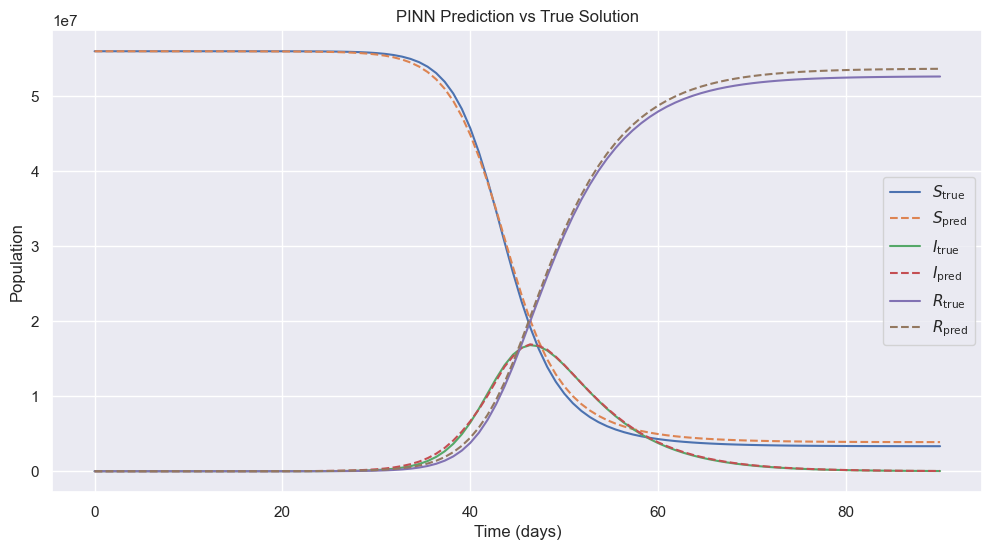

In [29]:
plt.subplots(figsize=(12, 6))

sns.lineplot(x=t_test, y=S_true, label="$S_{\mathrm{true}}$")
sns.lineplot(x=t_test, y=S_pred, label="$S_{\mathrm{pred}}$", linestyle="--")
sns.lineplot(x=t_test, y=I_true, label="$I_{\mathrm{true}}$")
sns.lineplot(x=t_test, y=I_pred, label="$I_{\mathrm{pred}}$", linestyle="--")
sns.lineplot(x=t_test, y=R_true, label="$R_{\mathrm{true}}$")
sns.lineplot(x=t_test, y=R_pred, label="$R_{\mathrm{pred}}$", linestyle="--")

plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.title("PINN Prediction vs True Solution")
plt.legend()
plt.savefig(f"{assets_dir}/predictions.png")
plt.show()

### Accuracy

Compute the Mean Squared Error between the true solution and the predicted solution.

In [30]:
mse_S = np.mean((S_true - S_pred) ** 2)
mse_I = np.mean((I_true - I_pred) ** 2)
mse_R = np.mean((R_true - R_pred) ** 2)

MSEs = pd.DataFrame(
  {
    "Component": ["Susceptible", "Infected", "Recovered"],
    "MSE":       [mse_S, mse_I, mse_R]
  },
)

MSEs["MSE"] = MSEs["MSE"].map("{:.2e}".format)

from IPython.display import display, HTML

display(HTML(MSEs.to_html(index=False)))

Component,MSE
Susceptible,3.06e+11
Infected,1.66e+10
Recovered,4.22e+11


### Conclusion

The model was able to predict the SIR model but with margin for improvement.

The MSEs are high, but the model was able to capture the dynamics of the system.